深度学习模型是“黑盒”，即模型学到的表示很难用人类可以理解的方式来提取和呈现。虽然对于某些类型的深度学习模型来说，这种说法部分正确，但对卷积神经网络来说绝对不是这样。卷积神经网络学到的表示非常适合可视化，很大程度上是因为它们是视觉概念的表示。自`2013`年以来，人们开发了多种技术来对这些表示进行可视化和解释。

* 可视化卷积神经网络的**中间输出（中间激活）**：有助于理解卷积神经网络连续的**层如何对输入进行变换，也有助于初步了解卷积神经网络每个过滤器的含义。**（使用猫狗分类问题上从头开始训练的小型卷积神经网络）

* 可视化卷积神经网络的**过滤器**：有助于精确理解卷积神经网络中**每个过滤器容易接受的视觉模式或视觉概念**。（使用VGG16模型）

* 可视化图像中类激活的**热力图**：有助于理解图像的**哪个部分被识别为属于某个类别，从而可以定位图像中的物体**。（使用VGG16模型）

# 1 可视化中间激活

可视化中间激活，是指对于给定输入，展示网络中各个**卷积层和池化层输出的特征图**（层的输出通常被称为该层的激活，即激活函数的输出）。这让我们可以看到**输入如何被分解为网络学到的不同过滤器**。我们希望在**三个维度对特征图进行可视化：宽度、高度和深度（通道）**。每个通道都对应相对独立的特征，所以将这些特征图可视化的正确方法是**将每个通道的内容分别绘制成二维图像**。

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_1.h5')
model.summary()  # 作为提醒

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [3]:
# 预处理单张图像(即一张猫的图像，它不属于网络的训练图像)
img_path = r'D:\git\deep-learning-with-python\data\cats_and_dogs_small\test\cats\cat.1700.jpg'

# 将图像预处理为一个 4D 张量
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# 请记住，训练模型的输入数据都用这种方法预处理
img_tensor /= 255.

# 其形状为 (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


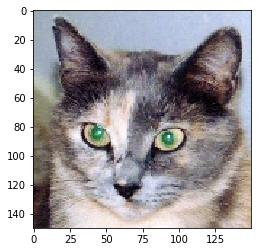

In [4]:
# 显示测试图像
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

为了提取想要查看的特征图，我们需要创建一个 Keras 模型，以图像批量作为输入，并输出所有卷积层和池化层的激活。为此，我们需要使用 Keras 的 Model 类。模型实例化需要两个参数：一个输入张量（或输入张量的列表）和一个输出张量（或输出张量的列表）。得到的类是一个Keras 模型，就像你熟悉的 Sequential 模型一样，将特定输入映射为特定输出。Model 类允许
模型有多个输出，这一点与 Sequential 模型不同。

In [5]:
# 用一个输入张量和一个输出张量列表将模型实例化
from keras import models

# 提取前 8 层的输出
layer_outputs = [layer.output for layer in model.layers[:8]]

# 创建一个模型，给定模型输入，可以返回这些输出
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

输入一张图像，这个模型将返回原始模型前 `8` 层的激活值。这是你在本书中第一次遇到的**多输出模型，之前的模型都是只有一个输入和一个输出**。一般情况下，**模型可以有任意个输入和输出**。这个模型有**一个输入和`8`个输出，即每层激活对应一个输出**。

In [18]:
# 以预测模式运行模型

# 返回8个Numpy数组组成的列表，每个层激活对应一个 Numpy 数组
activations = activation_model.predict(img_tensor)

In [19]:
# 对于输入的猫图像，第一个卷积层的激活
first_layer_activation = activations[0]
print(first_layer_activation.shape)

# 大小为 148×148 的特征图，有 32 个通道

(1, 148, 148, 32)


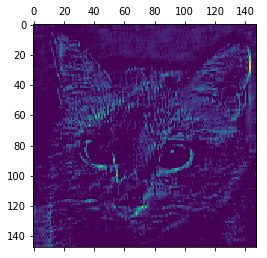

In [20]:
# 绘制原始模型第一层激活的第 4 个通道
# 将第 4 个通道可视化——对角边缘检测器(通道可能与此不同，因为卷积层学到的过滤器并不是确定的)

import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

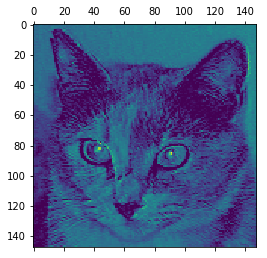

In [21]:
# 将第 7 个通道可视化——“鲜绿色圆点”检测器，对寻找猫眼睛很有用

plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

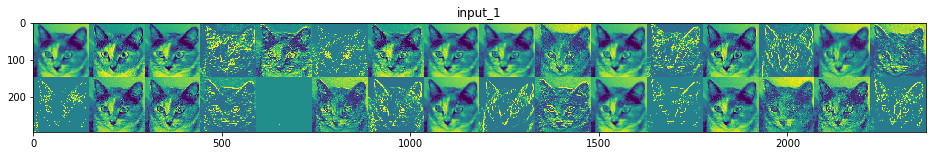

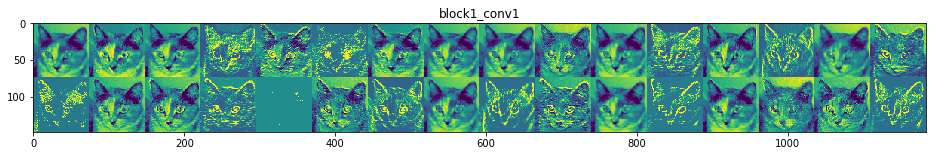

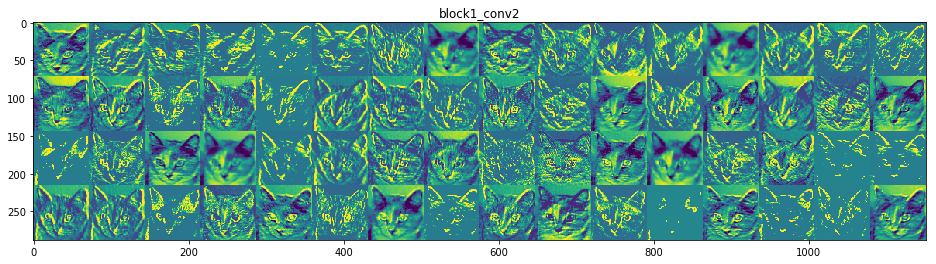

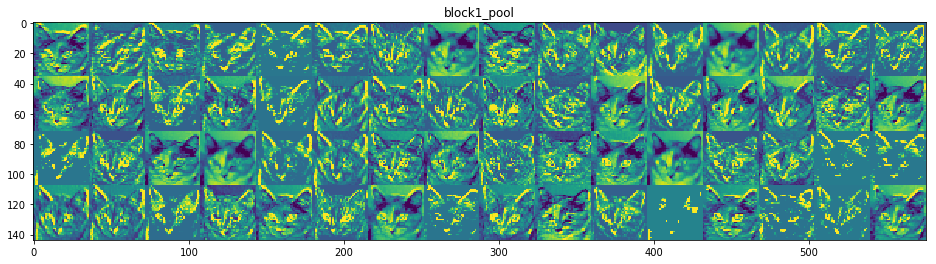

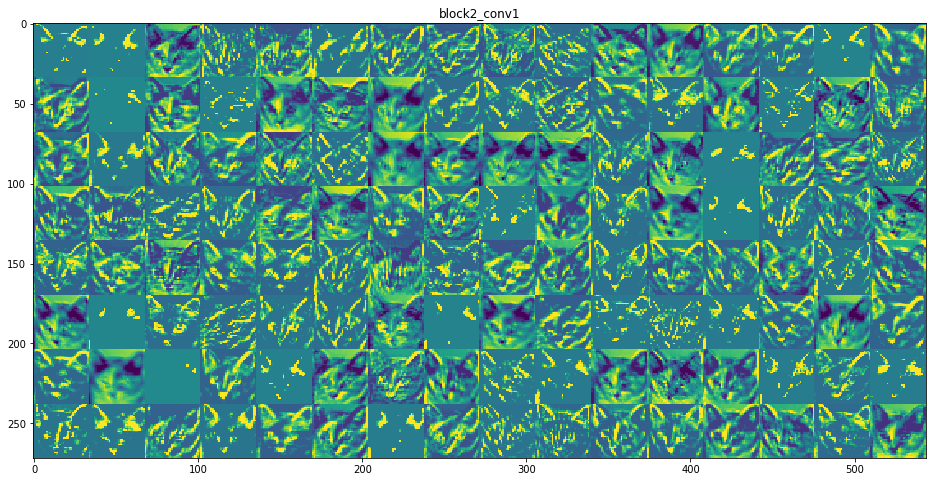

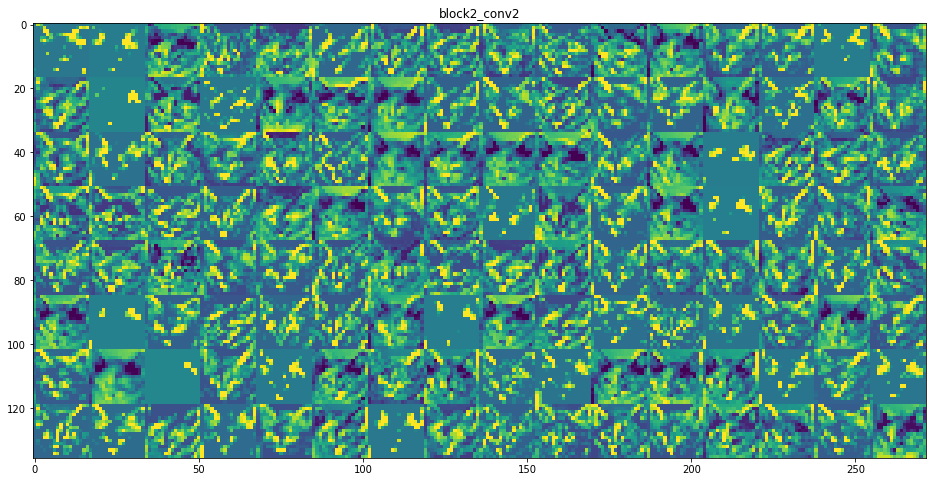

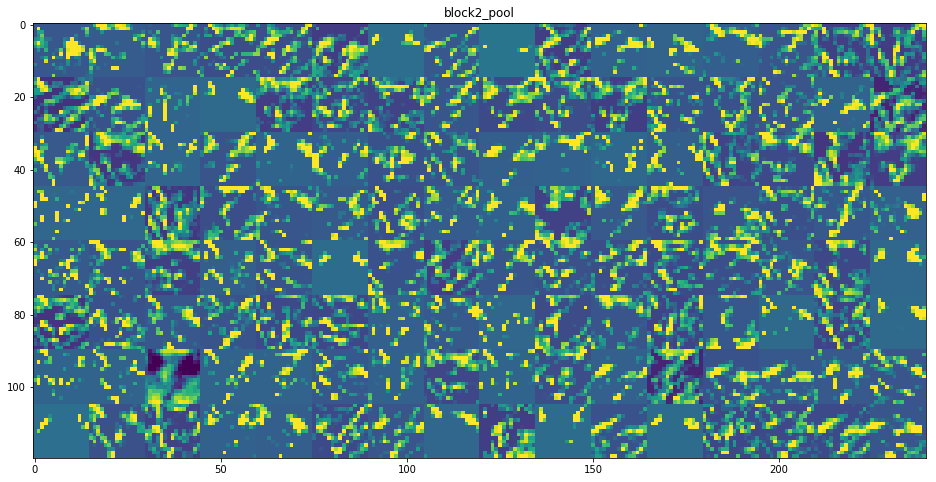

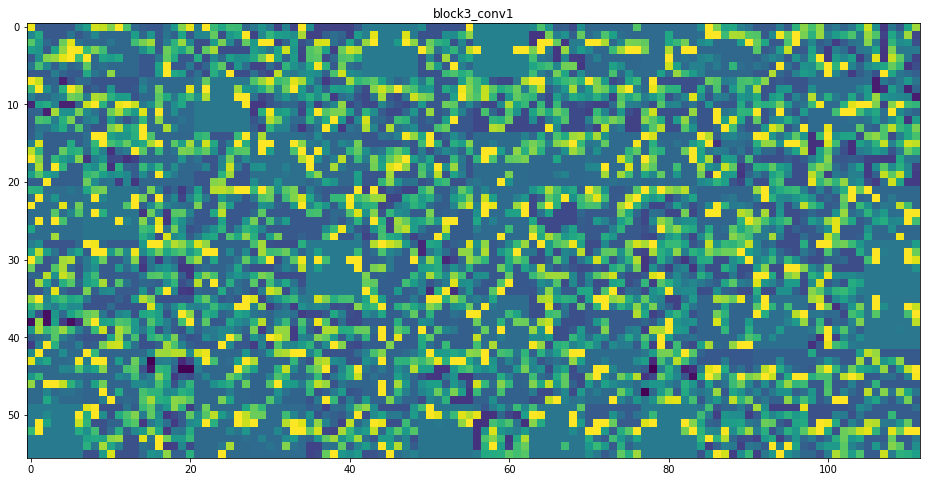

In [22]:
# 将每个中间激活的所有通道可视化
# 在 8 个特征图中的每一个中提取并绘制每一个通道，然后将结果叠加在一个大的图像张量中，按通道并排。
import keras

# 层的名称，这样你可以将这些名称画到图中
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 显示特征图
for layer_name, layer_activation in zip(layer_names, activations):
    # 特征图中的特征个数
    n_features = layer_activation.shape[-1]

    # 特征图的形状为(1, size, size, n_features)
    size = layer_activation.shape[1]

    # 在这个矩阵中将激活通道平铺
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 将每个过滤器平铺到一个大的水平网格中
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 对特征进行后处理，使其看起来更美观
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 显示网格
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

需要注意以下几点。
* 第一层是各种边缘探测器的集合。在这一阶段，激活几乎保留了原始图像中的所有信息。
* **随着层数的加深，激活变得越来越抽象，并且越来越难以直观地理解**。它们开始表示更高层次的概念，比如“猫耳朵”和“猫眼睛”。**层数越深，其表示中关于图像视觉内容的信息就越少，而关于类别的信息就越多。**
* **激活的稀疏度（sparsity）随着层数的加深而增大**。在第一层里，所有过滤器都被输入图像激活，但在后面的层里，越来越多的过滤器是空白的。也就是说，输入图像中找不到这些过滤器所编码的模式。

> 深度神经网络学到的表示的一个重要普遍特征：**随着层数的加深，层所提取的特征变得越来越抽象。更高的层激活包含关于特定输入的信息越来越少，而关于目标的信息越来越多（本例中即图像的类别：猫或狗）。**

> 这与人类和动物感知世界的方式类似：人类观察一个场景几秒钟后，可以记住其中有哪些抽象物体（比如自行车、树），但记不住这些物体的具体外观。事实上，如果你试着凭记忆画一辆普通自行车，那么很可能完全画不出真实的样子，虽然你一生中见过上千辆自行车（见图 5-28）。你可以现在就试着画一下，这个说法绝对是真实的。你的大脑已经学会将视觉输入完全抽象化，即将其转换为更高层次的视觉概念，同时过滤掉不相关的视觉细节，这使得大脑很难记住周围事物的外观。

# 2 可视化卷积神经网络的过滤器

观察卷积神经网络学到的过滤器，另一种简单的方法是显示每个过滤器所响应的视觉模式。这可以通过在输入空间中进行梯度上升来实现：从空白输入图像开始，将梯度下降应用于卷积神经网络输入图像的值，其目的是让某个过滤器的响应最大化。得到的输入图像是选定过滤器具有最大响应的图像。

我们需要构建一个损失函数，其目的是让某个卷积层的某个过滤器的值最大化；然后，我们要使用随机梯度下降来调节输入图像的值，以便让这个激活值最大化。例如，对于在ImageNet上预训练的VGG16网络，其block3_conv1层第0个过滤器激活的损失如下所示。

In [23]:
# 为过滤器的可视化定义损失张量
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# 为了实现梯度下降，我们需要得到损失相对于模型输入的梯度。
# 为此，我们需要使用 Keras的 backend 模块内置的 gradients 函数。

# 获取损失相对于输入的梯度
# ：调用 gradients 返回的是一个张量列表（本例中列表长度为1）。因此，只保留第一个元素，它是一个张量
grads = K.gradients(loss, model.input)[0]

为了让梯度下降过程顺利进行，一个非显而易见的技巧是将梯度张量除以其 L2 范数（张量中所有值的平方的平均值的平方根）来标准化。这就确保了输入图像的更新大小始终位于相同的范围。

In [24]:
# 梯度标准化：做除法前加上 1e–5，以防不小心除以 0
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) 

现在你需要一种方法：给定输入图像，它能够计算损失张量和梯度张量的值。你可以定义一个 Keras 后端函数来实现此方法：iterate 是一个函数，它将一个 Numpy 张量（表示为长度为 1 的张量列表）转换为两个 Numpy 张量组成的列表，这两个张量分别是损失值和梯度值。

In [25]:
# 给定 Numpy 输入值，得到 Numpy 输出值
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [26]:
# 通过随机梯度下降让损失最大化
# 从一张带有噪声的灰度图像开始
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# 运行 40 次梯度上升
step = 1.  # 每次梯度更新的步长
for i in range(40):
    # 计算损失值和梯度值
    loss_value, grads_value = iterate([input_img_data])
    # 沿着让损失最大化的方向调节输入图像
    input_img_data += grads_value * step

得到的图像张量是形状为 `(1, 150, 150, 3)` 的浮点数张量，其取值可能不是 `[0, 255]` 区间内的整数。
因此，你需要对这个张量进行后处理，将其转换为可显示的图像。

In [27]:
# 将张量转换为有效图像的实用函数
def deprocess_image(x):
    # 对张量做标准化，使其均值为 0，标准差为 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # 将 x 裁切（clip）到 [0, 1] 区间
    x += 0.5
    x = np.clip(x, 0, 1)

    # 将 x 转换为 RGB 数组
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# 生成过滤器可视化的函数
def generate_pattern(layer_name, filter_index, size=150):
    # 构建一个损失函数，将该层第 n 个过滤器的激活最大化
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # 计算这个损失相对于输入图像的梯度
    grads = K.gradients(loss, model.input)[0]

    # 标准化技巧：将梯度标准化
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 返回给定输入图像的损失和梯度
    iterate = K.function([model.input], [loss, grads])
    
    # 从带有噪声的灰度图像开始
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 运行 40 次梯度上升
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

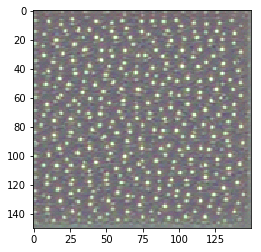

In [28]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


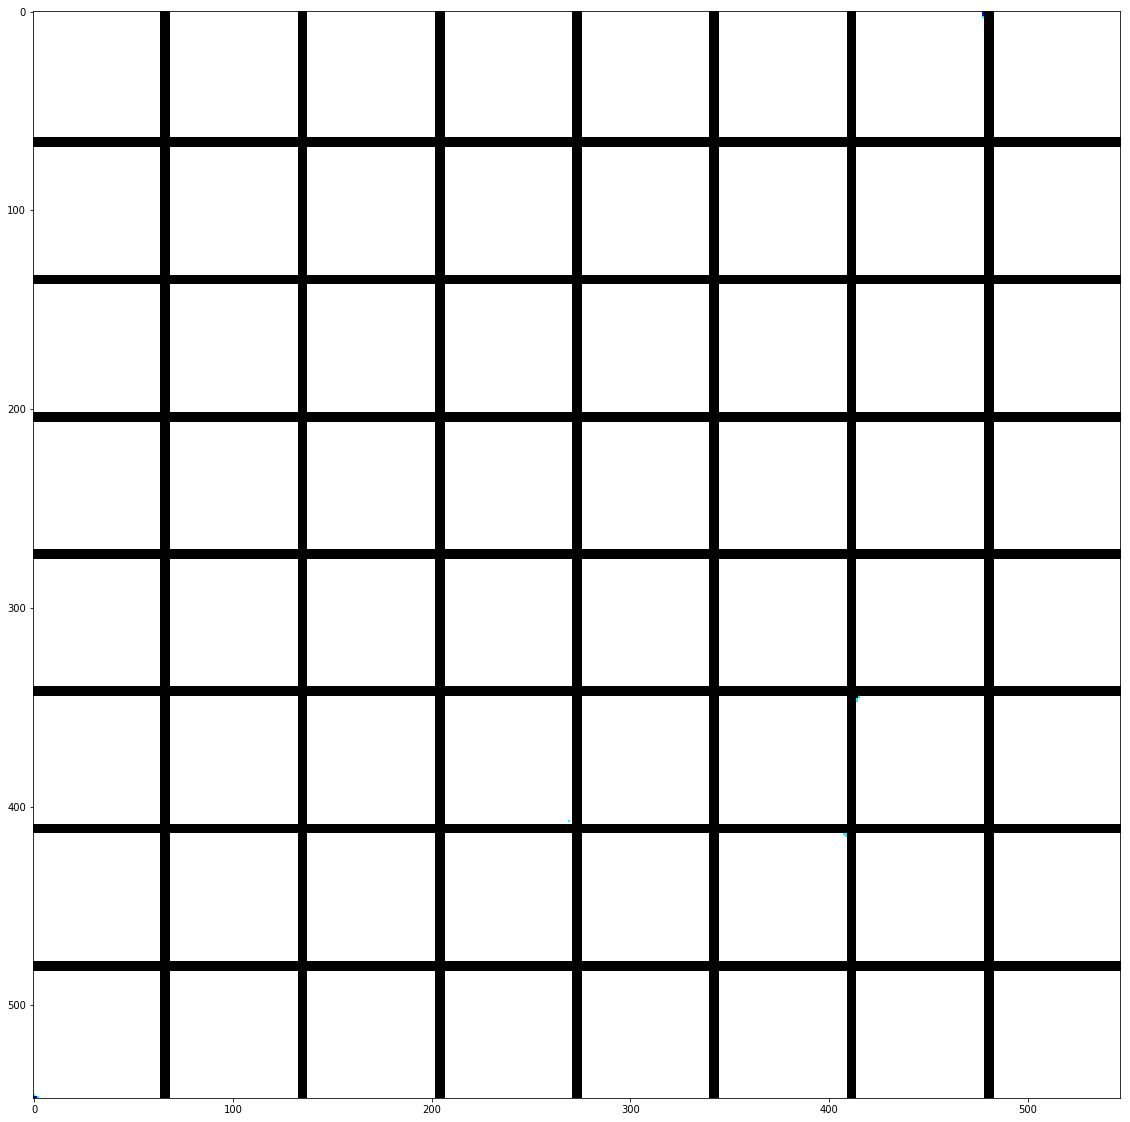

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


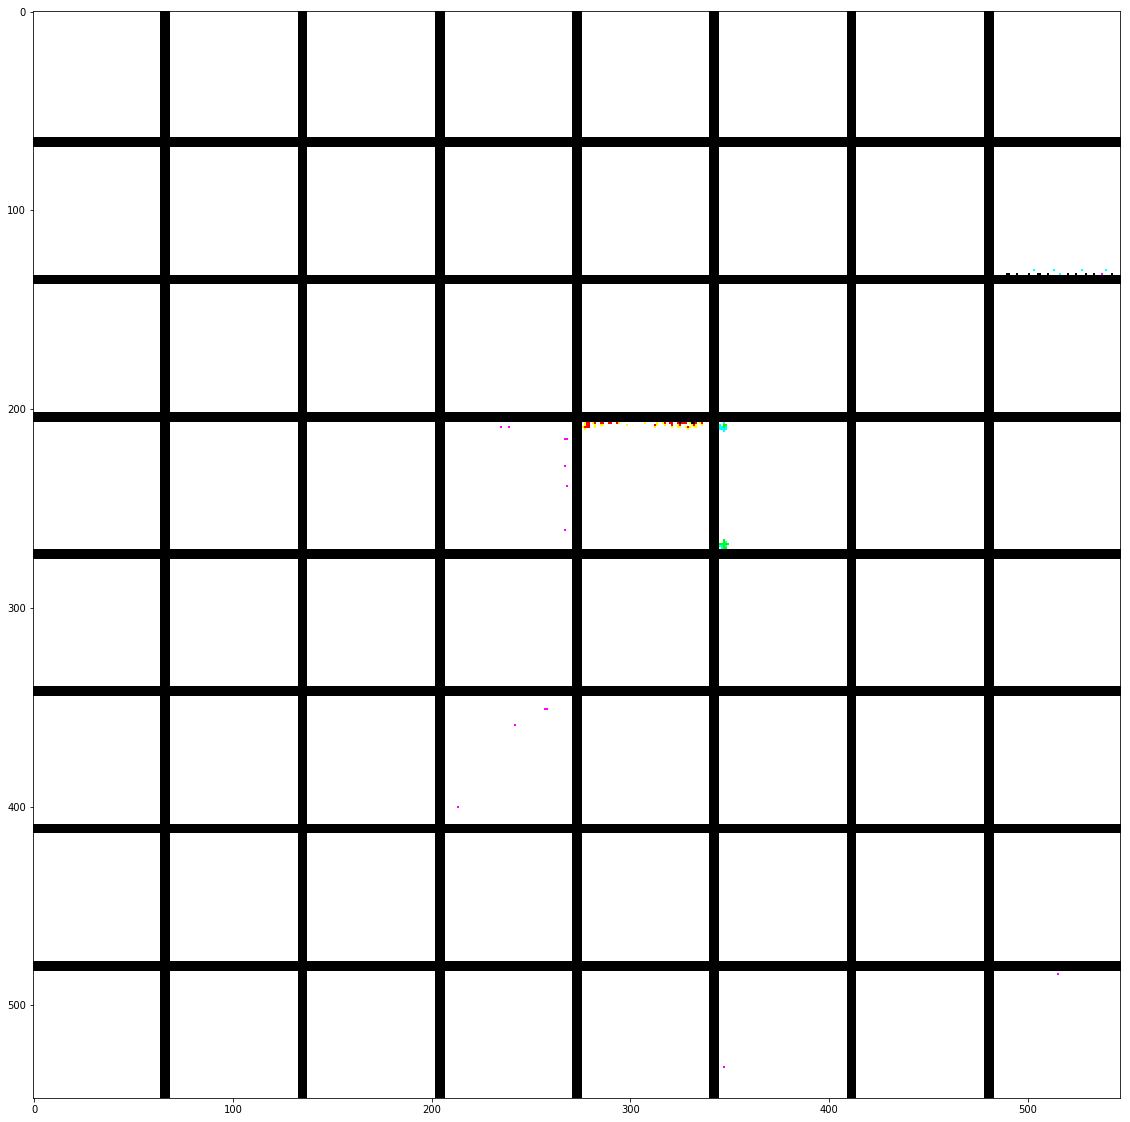

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


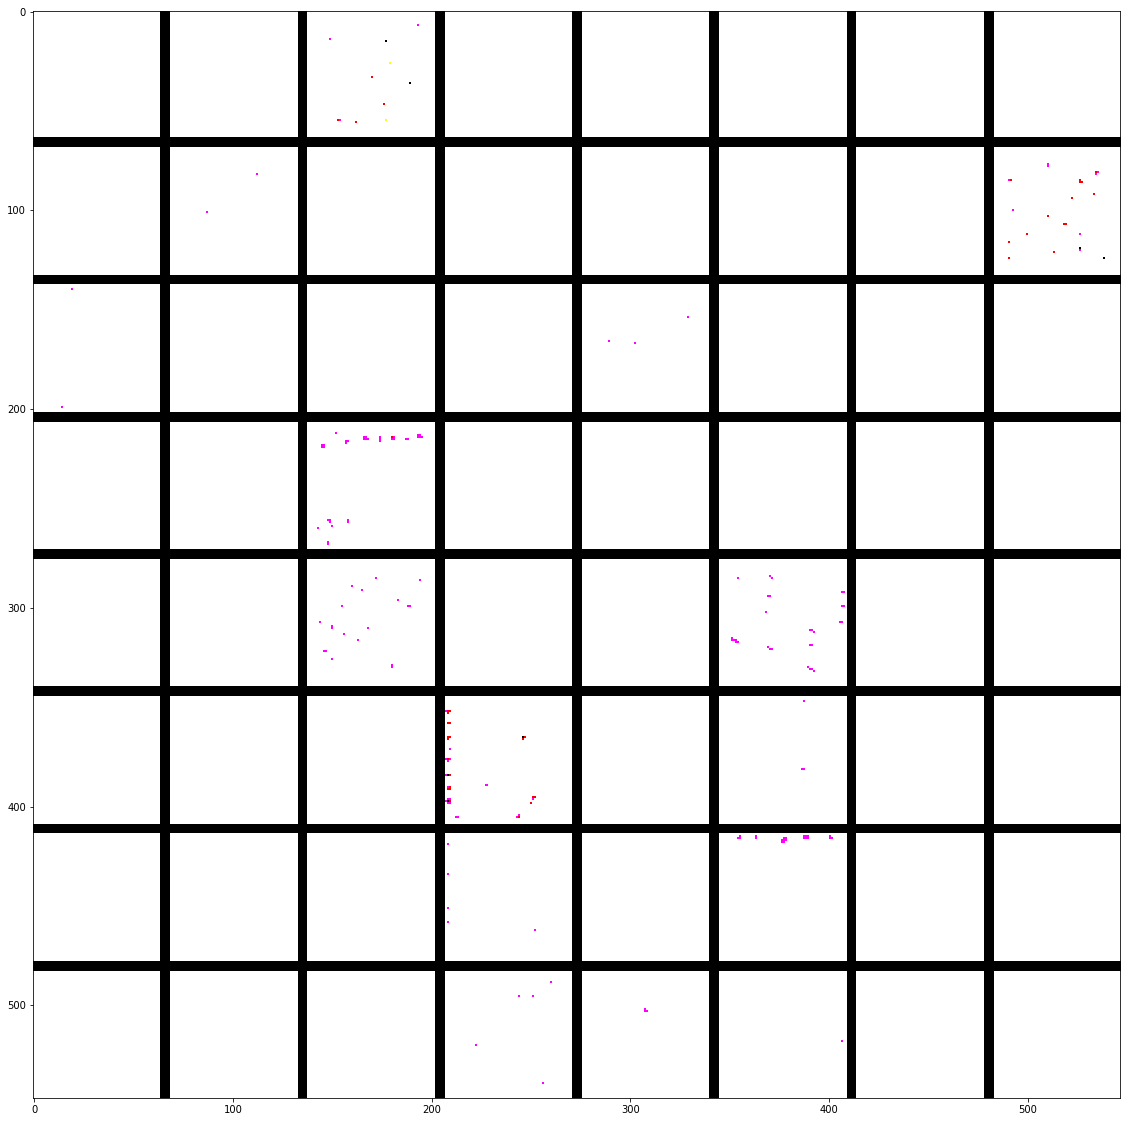

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


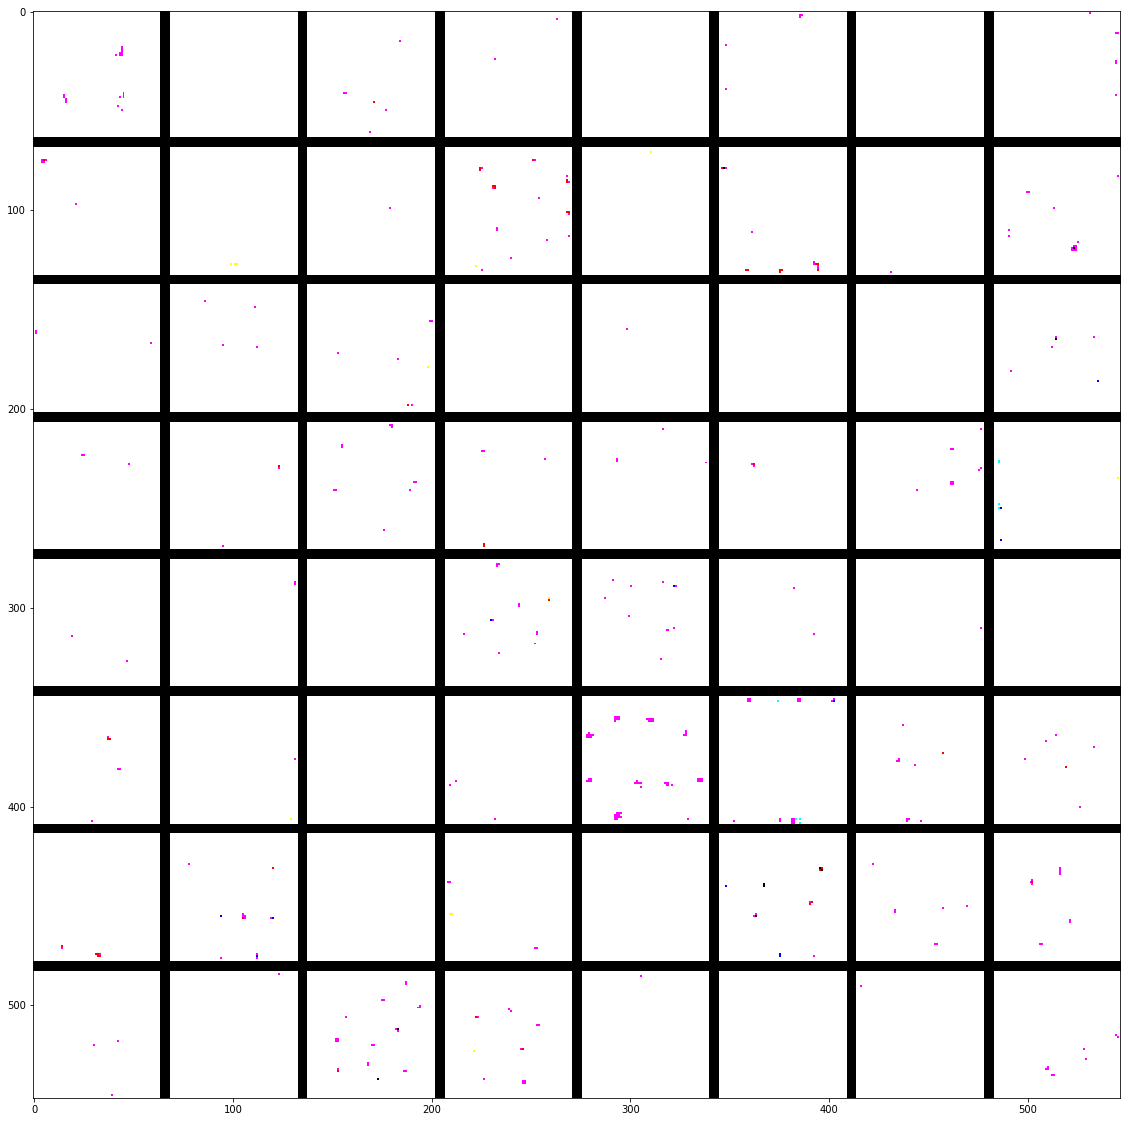

In [29]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # 空图像（全黑色），用于保存结果
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # 遍历 results 网格的行
        for j in range(8):  # 遍历 results 网格的列
            # 生成 layer_name层第i +（j * 8）个过滤器的模式
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # 将结果放到 results 网格第 (i, j) 个方块中
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # 显示 results 网格
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

这些过滤器可视化包含卷积神经网络的层如何观察世界的很多信息：卷积神经网络中每一层都学习一组过滤器，以便将其输入表示为过滤器的组合。这类似于傅里叶变换将信号分解为一组余弦函数的过程。随着层数的加深，卷积神经网络中的过滤器变得越来越复杂，越来越精细。
* 模型第一层（block1_conv1）的过滤器对应简单的方向边缘和颜色（还有一些是彩色边缘）。
* block2_conv1 层的过滤器对应边缘和颜色组合而成的简单纹理。
* 更高层的过滤器类似于自然图像中的纹理：羽毛、眼睛、树叶等。

# 3 可视化类激活的热力图

另一种可视化方法，它有助于了解一张图像的哪一部分让卷积神经网络做出了最终的分类决策。这有助于对卷积神经网络的决策过程进行调试，特别是出现分类错误的情况下。这种方法还可以定位图像中的特定目标。

这种通用的技术叫作类激活图（CAM，class activation map）可视化，它是指对输入图像生成类激活的热力图。类激活热力图是与特定输出类别相关的二维分数网格，对任何输入图像的每个位置都要进行计算，它表示每个位置对该类别的重要程度。举例来说，对于输入到猫狗分类卷积神经网络的一张图像，CAM 可视化可以生成类别“猫”的热力图，表示图像的各个部分与“猫”的相似程度，CAM 可视化也会生成类别“狗”的热力图，表示图像的各个部分与“狗”的相似程度。

我们将使用的具体实现方式是“Grad-CAM: visual explanations from deep networks via gradientbasedlocalization”这篇论文中描述的方法。这种方法非常简单：给定一张输入图像，对于一个卷积层的输出特征图，用类别相对于通道的梯度对这个特征图中的每个通道进行加权。直观上来看，理解这个技巧的一种方法是，你是用“每个通道对类别的重要程度”对“输入图像对不同通道的激活强度”的空间图进行加权，从而得到了“输入图像对类别的激活强度”的空间图。

我们再次使用预训练的 VGG16 网络来演示此方法。

In [30]:
# 加载带有预训练权重的 VGG16 网络
from keras.applications.vgg16 import VGG16

K.clear_session()

# 注意，网络中包括了密集连接分类器。在前面所有的例子中，我们都舍弃了这个分类器
model = VGG16(weights='imagenet')

In [31]:
# 为 VGG16 模型预处理一张输入图像

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# 目标图像的本地路径
img_path = r'D:\git\deep-learning-with-python\data\creative_commons_elephant.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# 添加一个维度，将数组转换为(1, 224, 224, 3) 形状的批量
x = np.expand_dims(x, axis=0)

# 对批量进行预处理（按通道进行颜色标准化）
x = preprocess_input(x)

In [32]:
# 你可以在图像上运行预训练的 VGG16 网络，并将其预测向量解码为人类可读的格式
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 7us/step
Predicted: [('n02504458', 'African_elephant', 0.9101747), ('n01871265', 'tusker', 0.08544492), ('n02504013', 'Indian_elephant', 0.004336897)]


对这张图像预测的前三个类别分别为：
* 非洲象（African elephant，92.5% 的概率）
* 长牙动物（tusker，7% 的概率）
* 印度象（Indian elephant，0.4% 的概率）

In [33]:
# 网络识别出图像中包含数量不确定的非洲象。预测向量中被最大激活的元素是对应“非洲象”类别的元素，索引编号为 386
np.argmax(preds[0])

386

In [34]:
# 应用 Grad-CAM 算法
# 预测向量中的“非洲象”元素
african_elephant_output = model.output[:, 386]

# block5_conv3 层的输出特征图，它是 VGG16 的最后一个卷积层
last_conv_layer = model.get_layer('block5_conv3')

# “非洲象”类别相对于 block5_conv3输出特征图的梯度
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# 形状为 (512,) 的向量，每个元素是特定特征图通道的梯度平均大小
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 访问刚刚定义的量：对于给定的样本图像，pooled_grads 和 block5_conv3 层的输出特征图
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 对于两个大象的样本图像，这两个量都是 Numpy 数组
pooled_grads_value, conv_layer_output_value = iterate([x])

# 将特征图数组的每个通道乘以“这个通道对‘大象’类别的重要程度”
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 得到的特征图的逐通道平均值即为类激活的热力图
heatmap = np.mean(conv_layer_output_value, axis=-1)

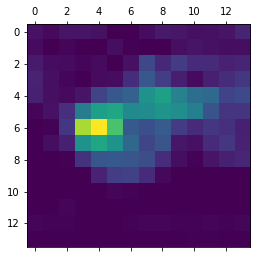

In [35]:
# 热力图后处理
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [39]:
!pip install opencv-python

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [40]:
# 可以用 OpenCV 来生成一张图像，将原始图像叠加在刚刚得到的热力图上
import cv2

# 用cv2 加载原始图像
img = cv2.imread(img_path)

# 将热力图的大小调整为与原始图像相同
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# 将热力图转换为 RGB 格式
heatmap = np.uint8(255 * heatmap)

# 将热力图应用于原始图像
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 这里的 0.4 是热力图强度因子
superimposed_img = heatmap * 0.4 + img

# 将图像保存到硬盘
cv2.imwrite(r'D:\git\deep-learning-with-python\data\elephant_cam.jpg', superimposed_img)

True

这种可视化方法回答了两个重要问题：
* 网络为什么会认为这张图像中包含一头非洲象？
* 非洲象在图像中的什么位置？
尤其值得注意的是，小象耳朵的激活强度很大，这可能是网络找到的非洲象和印度象的不
同之处。